In [ ]:
!pip install chromadb

In [ ]:
!pip install -U langchain-community
#!pip install -U langchain-community
#!pip install faiss-cpu
#!pip install chromadb

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader, WebBaseLoader
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

In [ ]:
# loading from two sources
loader = TextLoader("/content/drive/MyDrive/lab/dataset/mental_health.txt")
txt_documents_1 = loader.load()
# web_loader = WebBaseLoader("https://pmc.ncbi.nlm.nih.gov/articles/PMC9902068/")
# web_documents = web_loader.load()
# documents = txt_documents + web_documents

loader = TextLoader("/content/drive/MyDrive/lab/dataset/health_blog.txt")
txt_documents_2 = loader.load()
documents = txt_documents_1 + txt_documents_2

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(documents)
#RecursiveCharacterTextSplitter for production workloads

In [ ]:
print(docs)

[Document(metadata={'source': '/content/drive/MyDrive/lab/dataset/mental_health.txt'}, page_content='Title: The Impact of Physical Exercise on Mental Health Outcomes'), Document(metadata={'source': '/content/drive/MyDrive/lab/dataset/mental_health.txt'}, page_content='Introduction:\nMental health disorders, including depression and anxiety, represent a leading cause of disability worldwide. In recent decades, non-pharmacological interventions have gained increasing attention. Among these, physical exercise is recognized as a cost-effective and accessible method to improve mental health. This paper explores the evidence linking physical exercise with psychological well-being, focusing on both short-term and long-term outcomes.'), Document(metadata={'source': '/content/drive/MyDrive/lab/dataset/mental_health.txt'}, page_content='Background:\nPrevious literature suggests that exercise can enhance mood, reduce stress, and improve sleep quality. Neurobiological mechanisms such as increased 

In [ ]:
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

In [ ]:
vectorstore = Chroma.from_documents(docs, embedding_model)

In [ ]:
# #Can use FAISS if need persistence
# vectorstore = FAISS.from_documents(docs, embedding_model)
# vectorstore.save_local("/content/drive/MyDrive/lab/faiss_index")
# # can load from local
# vectorstore = FAISS.load_local(
#     "/content/drive/MyDrive/lab/faiss_index",
#     embedding_model,
#     allow_dangerous_deserialization=True
# )

In [ ]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

In [ ]:
#Invoking pipeline object for generating text responses.
qa_pipeline = pipeline(
    "text-generation",
    model=model_name,
    max_new_tokens=200,
    temperature=0.7,
    device_map="auto"
)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
llm = HuggingFacePipeline(pipeline=qa_pipeline)

/tmp/ipython-input-321326249.py:1: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=qa_pipeline)


In [ ]:

qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_type="similarity"),
    chain_type="stuff"
)
# retriever Decide which documents to pull
# By default, it just finds the top-k most similar documents by cosine similarity.
# chain_type="stuff". simple. other options - refine, map_reduce

In [ ]:
# Retrieve with Sources
from langchain.chains import RetrievalQAWithSourcesChain
qa = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever()
)
query = "Which type of exercise was more effective for anxiety reduction?"
result = qa({"question": query})
print("Answer:", result["answer"])
print("Sources:", result["sources"])


Token indices sequence length is longer than the specified maximum sequence length for this model (2208 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Answer: Given the following extracted parts of a long document and a question, create a final answer with references ("SOURCES").
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.


Sources: Which state/country's law governs the interpretation of the contract?


In [ ]:

query = "What does the document say about ?"
result = qa.run(query)
print(result)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Data Collection:
Baseline measures included self-reported anxiety and depression scores, sleep diaries, and cognitive performance tests. Physiological data such as heart rate variability and cortisol levels were also collected. Assessments were repeated at 6 weeks and 12 weeks.

Limitations:
The study relied on self-reported data for some measures, which may introduce bias. Additionally, the sample was limited to healthy adults; results may differ in clinical populations. Future research should explore the long-term sustainability of benefits and the biological mechanisms underlying improvements.

Title: The Impact of Physical Exercise on Mental Health Outcomes

Future Directions:
Future trials should examine different exercise intensities, durations, and modalities (e.g., yoga, dance, team sports). There is also a need to i

In [ ]:

query = "Which type of exercise was more effective for anxiety reduction? ?"
result = qa.run(query)
print(result)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Discussion:
These findings suggest that exercise is a powerful intervention for mental health. The benefits appear across multiple domains, including mood, cognition, and physiological regulation. Aerobic exercise demonstrated stronger effects on anxiety, while strength training was equally effective in reducing depressive symptoms. Importantly, improvements were observed as early as 6 weeks, with continued gains through 12 weeks.

Results:
1. Anxiety Reduction: Aerobic exercise participants showed a 25% decrease in anxiety scores compared to 10% in the strength training group and 2% in controls.
2. Depression Symptoms: Both aerobic and strength training groups reported significant reductions in depression symptoms, with aerobic exercise showing slightly greater improvements.
3. Sleep Quality: Exercise groups experienced imp

In [ ]:
# Result with Score
query = "Which type of exercise was more effective for anxiety reduction? ?"
query_embedding = embedding_model.embed_query(query)
docs_with_scores = vectorstore.as_retriever().get_relevant_documents(query)
doc_embeddings = [embedding_model.embed_query(d.page_content) for d in docs_with_scores]

scores = cosine_similarity([query_embedding], doc_embeddings)[0]


result = qa.run(query)

print("\nLLM Answer:  ")
print(result)

for doc, score in zip(docs_with_scores, scores):
    print(f"Score: {score:.3f} | Content: {doc.page_content[:300]}...")


LLM Answer:  
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Discussion:
These findings suggest that exercise is a powerful intervention for mental health. The benefits appear across multiple domains, including mood, cognition, and physiological regulation. Aerobic exercise demonstrated stronger effects on anxiety, while strength training was equally effective in reducing depressive symptoms. Importantly, improvements were observed as early as 6 weeks, with continued gains through 12 weeks.

Results:
1. Anxiety Reduction: Aerobic exercise participants showed a 25% decrease in anxiety scores compared to 10% in the strength training group and 2% in controls.
2. Depression Symptoms: Both aerobic and strength training groups reported significant reductions in depression symptoms, with aerobic exercise showing slightly greater improvements.
3. Sleep Quality: Exercise groups 

In [ ]:
#Embedding Visualization
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px


doc_texts = [d.page_content for d in docs]
doc_embeddings = embedding_model.embed_documents(doc_texts)
X = np.array(doc_embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
X_2d = tsne.fit_transform(X)


data = pd.DataFrame({
    "x": X_2d[:,0],
    "y": X_2d[:,1],
    "text": [doc.page_content[:300] for doc in docs],
    "section": [doc.metadata.get("section", "Unknown") for doc in docs]
})

# Plot with Plotly
fig = px.scatter(
    data, x="x", y="y",
    color="section",
    hover_data={"text": True},
    title="t-SNE Visualization of Document Embeddings"
)

fig.show()


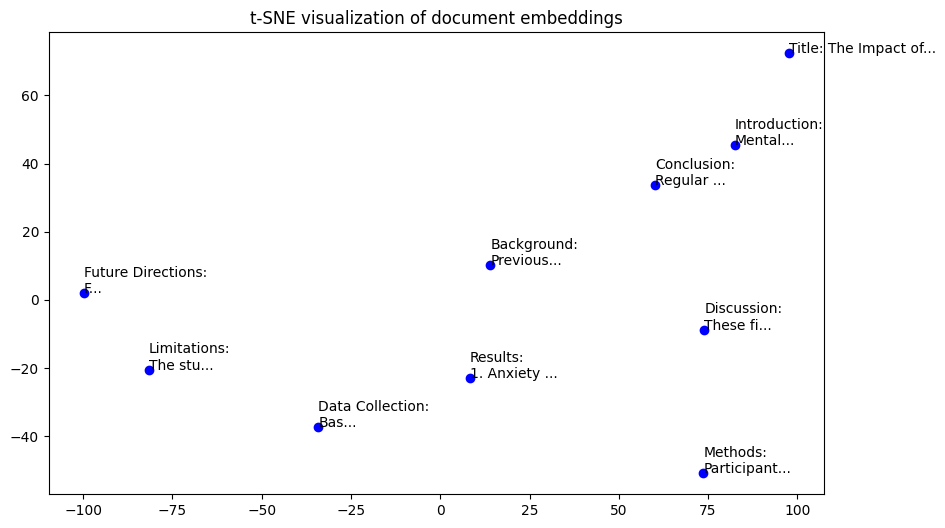

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

#Embeddings for each document chunk
doc_texts = [d.page_content for d in docs]
doc_embeddings = embedding_model.embed_documents(doc_texts)
np_doc_embeddings = np.array(doc_embeddings)
# # Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
reduced_embeddings = tsne.fit_transform(np_doc_embeddings)

# # Plot
plt.figure(figsize=(10,6))
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c="blue")
for i, txt in enumerate(doc_texts[:20]):  # label a few chunks
    plt.annotate(txt[:20] + "...", (reduced_embeddings[i,0], reduced_embeddings[i,1]))
plt.title("t-SNE visualization of document embeddings")
plt.show()



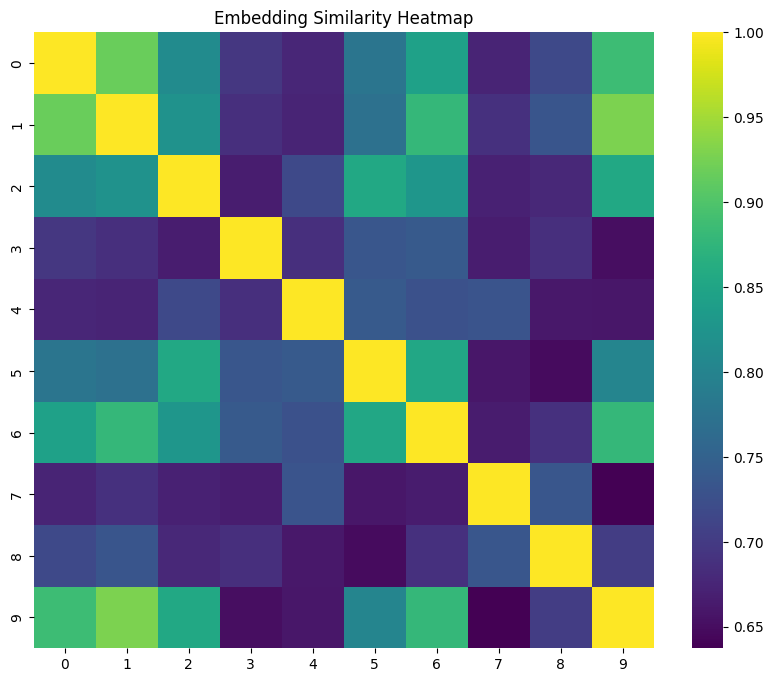

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute similarity matrix (cosine similarity)
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(np_doc_embeddings)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Embedding Similarity Heatmap")
plt.show()


In [ ]:
!pip install -U mcp

In [ ]:
# can wrap this RAG as a MCP Provider
from mcp.server import Server
from mcp.server import Server, tool

retriever = vectorstore.as_retriever()

server = Server("rag-provider")

@tool
async def retrieve_answer(query: str) -> str:
    """
    Retrieve an answer from the RAG pipeline.
    """
    return qa.run(query)

@tool
async def retrieve_chunks(query: str) -> dict:
    """
    Retrieve relevant chunks with similarity scores.
    """
    docs = retriever.get_relevant_documents(query)
    results = [
        {"content": d.page_content, "metadata": d.metadata}
        for d in docs
    ]
    return {"query": query, "results": results}

if __name__ == "__main__":
    server.run()

In [ ]:
'''
 Example Questions You Can Ask RAG

General comprehension

What was the main finding of the research paper?

How many studies were included in the review?

Specific detail

Which neurotransmitters are influenced by exercise according to the paper?

What percentage reduction in depressive symptoms was observed?

Comparison

Which type of exercise was more effective for anxiety reduction?

How did aerobic exercise compare with resistance training?

Implications

Why do the authors recommend including exercise in treatment guidelines?

How is exercise considered a cost-effective therapy?

Critical thinking

What are the limitations of using exercise as a treatment for mental health disorders?

What further research could build on these findings? '''